<a href="https://colab.research.google.com/github/igmim-yassine/Pytorch-Tutorial/blob/master/Tutorial_5_House_Price_Prediction_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tutorial 5- Kaggle Advance House Price Prediction Using Pytorch- Tabular Dataset

https://docs.fast.ai/tabular.html
https://www.fast.ai/2018/04/29/categorical-embeddings/
https://www.fast.ai/2018/04/29/categorical-embeddings/
https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/


1. Category Embedding


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('houseprice.csv', usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea", "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()

In [3]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000
...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,1999,953,694,175000
1456,20,RL,85.0,13175,Pave,Reg,1978,2073,0,210000
1457,70,RL,66.0,9042,Pave,Reg,1941,1188,1152,266500
1458,20,RL,68.0,9717,Pave,Reg,1950,1078,0,142125


In [4]:
#### create new columns
df['Total Years'] = datetime.datetime.now().year - df['YearBuilt']
df.drop("YearBuilt",axis=1,inplace=True)

In [5]:
cat_features = ["MSSubClass", "MSZoning", "Street", "LotShape"]
out_feature = ["SalePrice"]

In [6]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,60,RL,65.0,8450,Pave,Reg,856,854,208500,19
1,20,RL,80.0,9600,Pave,Reg,1262,0,181500,46
2,60,RL,68.0,11250,Pave,IR1,920,866,223500,21
3,70,RL,60.0,9550,Pave,IR1,961,756,140000,107
4,60,RL,84.0,14260,Pave,IR1,1145,1053,250000,22


In [7]:
# lbl_encoders={}
# lbl_encoders["MSSubClass"] = LabelEncoder()
# lbl_encoders["MSSubClass"].fit_transform(df["MSSubClass"])

In [8]:
# lbl_encoders

In [9]:
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature] = LabelEncoder()
    df[feature] = lbl_encoders[feature].fit_transform(df[feature])

In [10]:
df.reset_index(inplace = True)

In [11]:
df.drop(columns=['index'], inplace=True)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,5,3,65.0,8450,1,3,856,854,208500,19
1,0,3,80.0,9600,1,3,1262,0,181500,46
2,5,3,68.0,11250,1,0,920,866,223500,21
3,6,3,60.0,9550,1,0,961,756,140000,107
4,5,3,84.0,14260,1,0,1145,1053,250000,22
...,...,...,...,...,...,...,...,...,...,...
1196,5,3,62.0,7917,1,3,953,694,175000,23
1197,0,3,85.0,13175,1,3,2073,0,210000,44
1198,6,3,66.0,9042,1,3,1188,1152,266500,81
1199,0,3,68.0,9717,1,3,1078,0,142125,72


In [12]:
### Stacking and converting numpy Into Tensors
cat_features = np.stack([df['MSSubClass'],df['MSZoning'],df['Street'],df['LotShape']],1)
cat_features = torch.tensor(cat_features, dtype=torch.int64)
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [13]:
#### create continuous variable
cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)

In [14]:
### Stacking continuous variable to a tensor
cont_values = np.stack([df[i].values for i in cont_features], axis=1)
cont_values = torch.tensor(cont_values, dtype=torch.float)
cont_values

tensor([[   65.,  8450.,   856.,   854.,    19.],
        [   80.,  9600.,  1262.,     0.,    46.],
        [   68., 11250.,   920.,   866.,    21.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    81.],
        [   68.,  9717.,  1078.,     0.,    72.],
        [   75.,  9937.,  1256.,     0.,    57.]])

In [15]:
### Dependent Feature 
y = torch.tensor(df['SalePrice'].values, dtype=torch.float).reshape(-1,1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [16]:
cat_features.shape, cont_values.shape, y.shape

(torch.Size([1201, 4]), torch.Size([1201, 5]), torch.Size([1201, 1]))

In [17]:
#### Embedding Size For Categorical columns
cat_dims = [len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]

In [18]:
cat_dims

[15, 5, 2, 4]

In [19]:
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [20]:
embedding_dim

[(15, 8), (5, 3), (2, 1), (4, 2)]

In [21]:
embed_representation = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
embed_representation

ModuleList(
  (0): Embedding(15, 8)
  (1): Embedding(5, 3)
  (2): Embedding(2, 1)
  (3): Embedding(4, 2)
)

In [23]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,5,3,65.0,8450,1,3,856,854,208500,19
1,0,3,80.0,9600,1,3,1262,0,181500,46
2,5,3,68.0,11250,1,0,920,866,223500,21
3,6,3,60.0,9550,1,0,961,756,140000,107
4,5,3,84.0,14260,1,0,1145,1053,250000,22
...,...,...,...,...,...,...,...,...,...,...
1196,5,3,62.0,7917,1,3,953,694,175000,23
1197,0,3,85.0,13175,1,3,2073,0,210000,44
1198,6,3,66.0,9042,1,3,1188,1152,266500,81
1199,0,3,68.0,9717,1,3,1078,0,142125,72


In [22]:
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [24]:
cat_featuresz = cat_features[:4]
cat_featuresz

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        [6, 3, 1, 0]])

In [30]:
pd.set_option('display.max_rows', 500) 
embedding_val=[]
for i,e in enumerate(embed_representation):
    embedding_val.append(e(cat_features[:,i]))

In [31]:
embedding_val

[tensor([[ 0.2612, -0.8742, -0.0877,  ..., -1.0910,  0.7147, -0.3032],
         [ 0.7082, -1.1983, -0.0148,  ..., -0.2254,  1.5366, -0.4092],
         [ 0.2612, -0.8742, -0.0877,  ..., -1.0910,  0.7147, -0.3032],
         ...,
         [-0.9395,  0.8764, -0.7908,  ...,  0.8905, -1.2738,  0.9818],
         [ 0.7082, -1.1983, -0.0148,  ..., -0.2254,  1.5366, -0.4092],
         [ 0.7082, -1.1983, -0.0148,  ..., -0.2254,  1.5366, -0.4092]],
        grad_fn=<EmbeddingBackward0>), tensor([[-0.4744,  0.5659, -0.8111],
         [-0.4744,  0.5659, -0.8111],
         [-0.4744,  0.5659, -0.8111],
         ...,
         [-0.4744,  0.5659, -0.8111],
         [-0.4744,  0.5659, -0.8111],
         [-0.4744,  0.5659, -0.8111]], grad_fn=<EmbeddingBackward0>), tensor([[1.0783],
         [1.0783],
         [1.0783],
         ...,
         [1.0783],
         [1.0783],
         [1.0783]], grad_fn=<EmbeddingBackward0>), tensor([[ 0.5921,  0.4477],
         [ 0.5921,  0.4477],
         [-1.4472, -1.2880],
  

In [27]:
z = torch.cat(embedding_val, 1)
z

tensor([[ 0.2612, -0.8742, -0.0877,  ...,  1.0783,  0.5921,  0.4477],
        [ 0.7082, -1.1983, -0.0148,  ...,  1.0783,  0.5921,  0.4477],
        [ 0.2612, -0.8742, -0.0877,  ...,  1.0783, -1.4472, -1.2880],
        ...,
        [-0.9395,  0.8764, -0.7908,  ...,  1.0783,  0.5921,  0.4477],
        [ 0.7082, -1.1983, -0.0148,  ...,  1.0783,  0.5921,  0.4477],
        [ 0.7082, -1.1983, -0.0148,  ...,  1.0783,  0.5921,  0.4477]],
       grad_fn=<CatBackward0>)

In [34]:
#### Implement dropupout
droput=nn.Dropout(.3)

In [35]:
final_embed=droput(z)
final_embed

tensor([[ 0.3731, -1.2489, -0.0000,  ...,  1.5404,  0.8459,  0.6395],
        [ 1.0118, -0.0000, -0.0212,  ...,  1.5404,  0.8459,  0.0000],
        [ 0.3731, -1.2489, -0.0000,  ...,  1.5404, -2.0674, -0.0000],
        ...,
        [-0.0000,  0.0000, -1.1297,  ...,  1.5404,  0.8459,  0.6395],
        [ 1.0118, -0.0000, -0.0212,  ...,  0.0000,  0.8459,  0.0000],
        [ 1.0118, -1.7119, -0.0212,  ...,  1.5404,  0.8459,  0.6395]],
       grad_fn=<MulBackward0>)

In [36]:
##### Create a Feed Forward Neural Network
class FeedForwardNN(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.3):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [37]:
len(cont_features)

5

In [38]:
torch.manual_seed(100)
model = FeedForwardNN(embedding_dim, len(cont_features),1 ,[100,50] ,p=0.4)

In [39]:
model

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

#### Define Loss And Optimizer

In [40]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [41]:
df.shape

(1201, 10)

In [42]:
cont_values

tensor([[   65.,  8450.,   856.,   854.,    19.],
        [   80.,  9600.,  1262.,     0.,    46.],
        [   68., 11250.,   920.,   866.,    21.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    81.],
        [   68.,  9717.,  1078.,     0.,    72.],
        [   75.,  9937.,  1256.,     0.,    57.]])

In [43]:
cont_values.shape

torch.Size([1201, 5])

In [45]:
batch_size = 1200
test_size = int(batch_size*0.15)

size = batch_size-test_size

train_categorical = cat_features[:size]
test_categorical = cat_features[size:batch_size]

train_cont = cont_values[:size]
test_cont = cont_values[size:batch_size]

y_train = y[:size]
y_test = y[size:batch_size]

In [46]:
len(train_categorical), len(test_categorical), len(train_cont), len(test_cont), len(y_train), len(y_test)

(1020, 180, 1020, 180, 1020, 180)

In [ ]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred = model(train_categorical,train_cont)
    loss = torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

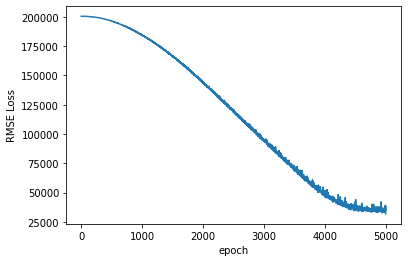

In [48]:
plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [51]:
#### Validate the Test Data
y_pred=""
with torch.no_grad():
    y_pred = model(test_categorical,test_cont)
    loss = torch.sqrt(loss_function(y_pred,y_test))
print('RMSE: {}'.format(loss))

RMSE: 44268.5703125


In [52]:
data_verify = pd.DataFrame(y_test.tolist(),columns=["Test"])

In [53]:
data_predicted = pd.DataFrame(y_pred.tolist(),columns=["Prediction"])

In [54]:
data_predicted

,Prediction
0,125476.164062
1,187342.968750
2,138012.984375
3,254597.875000
4,193496.406250
5,154462.656250
6,272720.968750
7,289497.968750
8,156748.234375
9,380199.343750


In [55]:
final_output = pd.concat([data_verify,data_predicted],axis=1)
final_output['Difference'] = final_output['Test']-final_output['Prediction']
final_output.head()

,Test,Prediction,Difference
0,130000.0,125476.164062,4523.835938
1,138887.0,187342.968750,-48455.968750
2,175500.0,138012.984375,37487.015625
3,195000.0,254597.875000,-59597.875000
4,142500.0,193496.406250,-50996.406250


In [ ]:
#### Saving The Model
#### Save the model
torch.save(model,'HousePrice.pt')

In [ ]:
torch.save(model.state_dict(),'HouseWeights.pt')

In [ ]:
### Loading the saved Model
embs_size=[(15, 8), (5, 3), (2, 1), (4, 2)]
model1=FeedForwardNN(embs_size,5,1,[100,50],p=0.4)

In [ ]:
model1.load_state_dict(torch.load('HouseWeights.pt'))

<All keys matched successfully>

In [ ]:
model1.eval()

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)